In [1]:
import sys
!{sys.executable} -m pip install scipy

In [2]:
import scipy
print(scipy.__version__)

1.15.3


In [3]:
# import algos and graphs
import sys
import os
import networkx as nx
import matplotlib.pyplot as plt
import gzip
import random
import time
import requests
import urllib3
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

# Add parent directory to path so algorithms can be imported
sys.path.append(os.path.abspath("../algorithms"))

# Import algorithms
from greedy import find_maximum_clique_from_dict
from local_search import local_search
from randomized import randomized_max_clique
from simulated_annealing import simulated_annealing_with_restarts
from bron_kerbosch import bron_kerbosch_with_pivot, bron_kerbosch_basic

print("All algorithms imported successfully.")


All algorithms imported successfully.


In [4]:
# import graphs
# --- Step 1: Helper to load .adj file ---
def load_adj_file(path):
    """
    Loads a graph stored in adjacency list format (.adj) and
    returns a dictionary {node: set(neighbors)} suitable for Bron–Kerbosch.
    """
    adj_dict = {}
    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            if ":" not in line:
                continue
            node, neighbors = line.strip().split(":", 1)
            node = node.strip()
            neighbor_set = set(neighbors.strip().split()) if neighbors.strip() else set()
            adj_dict[node] = neighbor_set
    return adj_dict

# --- Step 2: Load student cooperation graph ---
small_graph_dir = "../data/large_graphs"
all_adj_files = [f for f in os.listdir(small_graph_dir) if f.endswith(".adj")]

if not all_adj_files:
    raise FileNotFoundError(f"No .adj files found in {small_graph_dir}")

chosen_file = random.choice(all_adj_files)
adj_path = os.path.join(small_graph_dir, chosen_file)

print(f"📂 Loading graph from: {adj_path}")
G_dict = load_adj_file(adj_path)
print(f"✅ Graph loaded: {len(G_dict)} vertices ({chosen_file})")

📂 Loading graph from: ../data/large_graphs/facebook_combined.txt.adj
✅ Graph loaded: 4039 vertices (facebook_combined.txt.adj)



🔍 Running Greedy algorithm...

=== Greedy ===
Max Clique Nodes: ['2352', '1912', '2266', '1985', '2233', '2142', '2206', '2229', '2410', '2611', '2218', '2078', '1993', '2123', '2464', '2240', '2507', '2244', '1983', '2309', '2088', '2131', '2340', '2602', '2590', '2542', '2604', '2073', '2220', '2188', '2059', '2172', '1943', '2150', '1946', '2428', '2526', '2201', '2331', '2601', '1938', '2090', '2118', '2564', '2624', '1962', '2030', '2586', '2064', '2184', '2625', '2275', '2615', '2103', '2290', '2104', '2326', '2395', '2139', '2093', '2354', '2356', '2460', '2655', '2108', '2578', '2121', '2308']
Size: 68
Runtime: 8.5120 sec



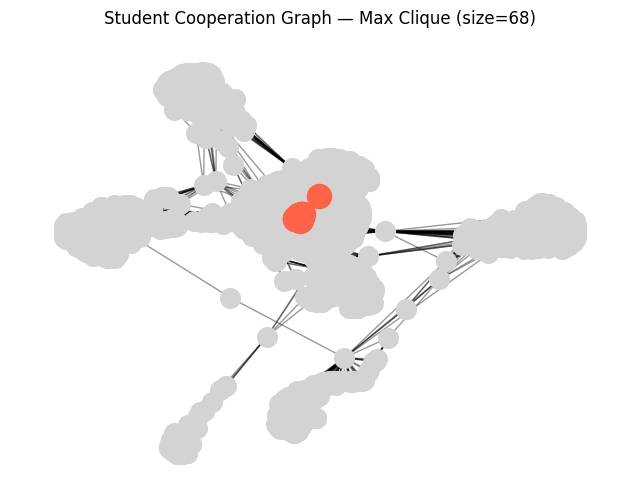

In [5]:
# Greedy
print("\n🔍 Running Greedy algorithm...\n")

start = time.time()
max_clique, runtime = find_maximum_clique_from_dict(G_dict)
end = time.time()

print("=== Greedy ===")
print(f"Max Clique Nodes: {max_clique}")
print(f"Size: {len(max_clique)}")
print(f"Runtime: {end - start:.4f} sec\n")

G_nx = nx.Graph()
for node, nbrs in G_dict.items():
    for nbr in nbrs:
        G_nx.add_edge(node, nbr)

pos = nx.spring_layout(G_nx, seed=42)

plt.figure(figsize=(8, 6))
nx.draw_networkx_nodes(G_nx, pos, node_color="lightgray", node_size=200)
nx.draw_networkx_edges(G_nx, pos, alpha=0.4)
nx.draw_networkx_nodes(G_nx, pos, nodelist=max_clique, node_color="tomato", node_size=300)
plt.title(f"Student Cooperation Graph — Max Clique (size={len(max_clique)})")
plt.axis("off")
plt.show()

In [ ]:
# Local search
print("\n🔍 Running Local Search algorithm...\n")

start = time.time()
max_clique, runtime = local_search(G_dict)
end = time.time()

print("=== Local Search ===")
print(f"Max Clique Nodes: {max_clique}")
print(f"Size: {len(max_clique)}")
print(f"Runtime: {end - start:.4f} sec\n")

G_nx = nx.Graph()
for node, nbrs in G_dict.items():
    for nbr in nbrs:
        G_nx.add_edge(node, nbr)

pos = nx.spring_layout(G_nx, seed=42)

plt.figure(figsize=(8, 6))
nx.draw_networkx_nodes(G_nx, pos, node_color="lightgray", node_size=200)
nx.draw_networkx_edges(G_nx, pos, alpha=0.4)
nx.draw_networkx_nodes(G_nx, pos, nodelist=max_clique, node_color="tomato", node_size=300)
plt.title(f"Student Cooperation Graph — Max Clique (size={len(max_clique)})")
plt.axis("off")
plt.show()


🔍 Running Randomized algorithms...

=== Randomized ===
Max Clique Nodes: ['2482', '2369', '2103', '2347', '2602', '2121', '2354', '1943', '2356', '2309', '2201', '2206', '2601', '2123', '2560', '2324', '2240', '2363', '1985', '2244', '2604', '2542', '1993', '2045', '2090', '2326', '2118', '1962', '2334', '1912', '2561', '2078', '2073', '2220', '2142', '2464', '2331', '2064', '2410', '2376', '2507', '2500', '2586', '2395', '2184', '2218', '2233', '1946', '2266', '2428', '2229', '2131', '2655', '1938', '2430', '1984']
Size: 56
Runtime: 0.0115 sec



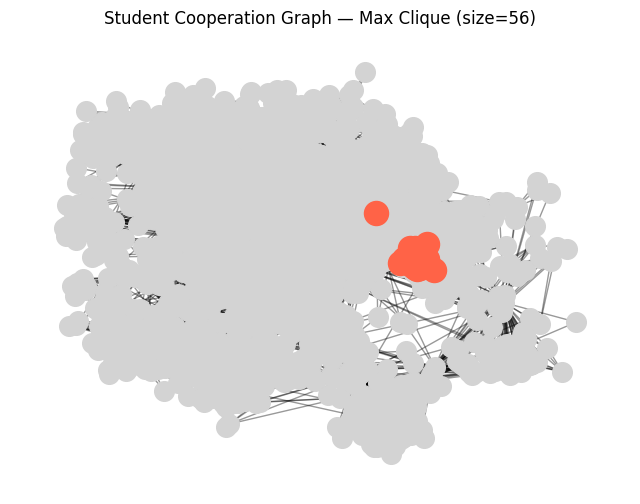

In [4]:
# randomized
print("\n🔍 Running Randomized algorithms...\n")

start = time.time()
size, max_clique, _ = randomized_max_clique(G_dict)
end = time.time()

print("=== Randomized ===")
print(f"Max Clique Nodes: {max_clique}")
print(f"Size: {len(max_clique)}")
print(f"Runtime: {end - start:.4f} sec\n")

G_nx = nx.Graph()
for node, nbrs in G_dict.items():
    for nbr in nbrs:
        G_nx.add_edge(node, nbr)

pos = nx.spring_layout(G_nx, seed=42)

plt.figure(figsize=(8, 6))
nx.draw_networkx_nodes(G_nx, pos, node_color="lightgray", node_size=200)
nx.draw_networkx_edges(G_nx, pos, alpha=0.4)
nx.draw_networkx_nodes(G_nx, pos, nodelist=max_clique, node_color="tomato", node_size=300)
plt.title(f"Student Cooperation Graph — Max Clique (size={len(max_clique)})")
plt.axis("off")
plt.show()

In [ ]:
# local_random


In [ ]:
# Simulated Annealing
print("\n🔍 Running Simulated Annealing algorithms...\n")

start = time.time()
# idk what to put here!
end = time.time()

print("=== Simulated Annealing ===")
print(f"Max Clique Nodes: {max_clique}")
print(f"Size: {len(max_clique)}")
print(f"Runtime: {end - start:.4f} sec\n")

G_nx = nx.Graph()
for node, nbrs in G_dict.items():
    for nbr in nbrs:
        G_nx.add_edge(node, nbr)

pos = nx.spring_layout(G_nx, seed=42)

plt.figure(figsize=(8, 6))
nx.draw_networkx_nodes(G_nx, pos, node_color="lightgray", node_size=200)
nx.draw_networkx_edges(G_nx, pos, alpha=0.4)
nx.draw_networkx_nodes(G_nx, pos, nodelist=max_clique, node_color="tomato", node_size=300)
plt.title(f"Student Cooperation Graph — Max Clique (size={len(max_clique)})")
plt.axis("off")
plt.show()

In [ ]:
# bron kerbosch
print("\n🔍 Running Bron–Kerbosch algorithm...\n")

# With pivot
start_pivot = time.time()
max_clique_pivot, runtime_pivot = bron_kerbosch_with_pivot(G_dict)
end_pivot = time.time()

# Basic
start_basic = time.time()
max_clique_basic, runtime_basic = bron_kerbosch_basic(G_dict)
end_basic = time.time()

# --- Step 4: Display Results ---
print("=== Bron–Kerbosch (With Pivoting) ===")
print(f"Max Clique Nodes: {max_clique_pivot}")
print(f"Size: {len(max_clique_pivot)}")
print(f"Runtime: {end_pivot - start_pivot:.4f} sec\n")

print("=== Bron–Kerbosch (Basic) ===")
print(f"Max Clique Nodes: {max_clique_basic}")
print(f"Size: {len(max_clique_basic)}")
print(f"Runtime: {end_basic - start_basic:.4f} sec\n")

# --- Step 5: Visualization (optional, small graphs only) ---
# Since student-cooperation has only ~185 nodes, visualization is possible
G_nx = nx.Graph()
for node, nbrs in G_dict.items():
    for nbr in nbrs:
        G_nx.add_edge(node, nbr)

pos = nx.spring_layout(G_nx, seed=42)

plt.figure(figsize=(8, 6))
nx.draw_networkx_nodes(G_nx, pos, node_color="lightgray", node_size=200)
nx.draw_networkx_edges(G_nx, pos, alpha=0.4)
nx.draw_networkx_nodes(G_nx, pos, nodelist=max_clique_pivot, node_color="tomato", node_size=300)
plt.title(f"Student Cooperation Graph — Max Clique (size={len(max_clique_pivot)})")
plt.axis("off")
plt.show()